---

### ⚠️ Note on Runtime (Please Read Before Running Any Training)

To keep this lab **time-efficient** and feasible within the **2-hour session**, the notebook provides **pre-executed results** for DQN, PPO, and A2C.  
Running deep RL algorithms from scratch can be slow:

- **DQN** → ~12 minutes  
- **PPO** → ~5 minutes  
- **A2C** → ~17 minutes  

Because of this, **you are not required to rerun any training cells** during the lab.

However:

- You *may* rerun an algorithm if you want to experiment or modify parameters,  
- And you *should* feel free to explore the code to understand how algorithms behave.

**Recommendation:**  
If you want to rerun training, do so **after the lab** or **only for one algorithm** (PPO is the fastest).

---


### ⚠️ Reproducibility Note

If you run this notebook using the **default CPU runtime** in Google Colab, your results should be
**identical** to the pre-executed outputs.  

However, if you switch to **GPU** or **TPU** mode, or run the notebook on your **own machine**, you may see differences in learning curves or final rewards. This is expected and has technical reasons:

- Deep-learning frameworks use low-level numerical libraries such as **BLAS**, **cuBLAS**, and **cuDNN**. Many operations in these libraries are **not fully deterministic**.
- GPUs and TPUs execute kernels in parallel, which introduces **nondeterministic thread scheduling**.
- Floating-point rounding and precision differ across hardware.
- Multithreading in NumPy/PyTorch can introduce tiny numerical variations.

These tiny differences accumulate over thousands of training updates in RL, leading to different results.

---



# Reinforcement Learning — Lab 5  
**Deep RL: DQN vs PPO vs A2C**

In this lab you will:

- First get familiar with the `LunarLander-v3` environment from **Gymnasium** using a simple **random policy**. ([Link to `LunarLander-v3`](https://gymnasium.farama.org/environments/box2d/lunar_lander/), [Link to `Gymnasium`](https://gymnasium.farama.org/introduction/basic_usage/))
- Then **train and compare** three deep RL algorithms using **Stable-Baselines3 (SB3)** on the same task:
  - DQN (off-policy, value-based) ([Link](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html))
  - PPO (on-policy, actor–critic) ([Link](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html))
  - A2C (on-policy, actor–critic) ([Link](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html))
- For each algorithm, you will:
  - Monitor episode rewards and episode lengths over time,
  - Record a video of the trained agent,
  - Compare performance and learning dynamics,
- Optionally redo the process for `CartPole-v1` environment. ([Link to `CartPole-v1`](https://gymnasium.farama.org/environments/classic_control/cart_pole/))

Your focus is on **interpreting learning curves**, **stability**, and **sample efficiency**, not boilerplate coding.



## You need to run this before doing the tasks:



### Setup

In [ ]:
!apt-get update && apt-get install swig cmake
!apt-get install -y ffmpeg freeglut3-dev xvfb  # For visualization
!pip install box2d-py
!pip install pandas
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install moviepy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,475 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,532 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis

### Imports and helper utilities

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# # Set up fake display; otherwise rendering will fail on Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ["DISPLAY"] = ":1"

import random
import glob
import base64
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
from IPython import display as ipythondisplay

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.logger import configure
from stable_baselines3.dqn import MlpPolicy

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
except Exception:
    pass


# ---------- Video helpers ----------

def show_videos(video_path="videos", prefix=""):
    """
    Display mp4 videos from a folder directly in the notebook.
    """
    video_path = Path(video_path)
    if not video_path.exists():
        print(f"No video folder {video_path} found.")
        return
    html = []
    for mp4 in video_path.glob(f"{prefix}*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            f"""
            <video alt="{mp4}" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
            </video>
            """
        )
    if html:
        ipythondisplay.display(ipythondisplay.HTML("<br>".join(html)))
    else:
        print(f"No videos with prefix '{prefix}' found in {video_path}.")


def record_video(env_id, model_vid=None, video_length=500, prefix="", video_folder="videos/", verbose=True, use_best=False, **env_kwargs):
    """
    Record a video of an agent acting in the environment.

    - If model is None, uses a random policy.
    - If model is a trained SB3 model, uses model.predict(...).

    Videos are saved as mp4 files in `video_folder`.
    """
    if not os.path.exists(video_folder):
      os.makedirs(video_folder, exist_ok=True)

    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array", **env_kwargs)])
    eval_env.seed(SEED)

    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    total_reward = 0
    steps = 0
    done = False
    Episode = 1

    # Optionally load the best saved model based on the model's own logger
    if use_best:
        if model_vid is None:
            raise ValueError("use_best=True but no model was passed to record_video.")
        log_dir = getattr(model_vid.logger, "dir", None)
        if log_dir is None:
            raise ValueError("Could not infer log_dir from model.logger. "
                             "Make sure you used configure(log_dir, ...) and model.set_logger(new_logger).")
        best_path = os.path.join(log_dir, "best_model.zip")
        if not os.path.exists(best_path):
            raise FileNotFoundError(f"No best_model.zip found at: {best_path}")
        print(f"Loading best model from {best_path}...")
        algo_cls = model_vid.__class__
        model_vid = algo_cls.load(best_path)

    if model_vid is None:
        eval_env.action_space.seed(SEED)
    for _ in range(video_length):
        if model_vid is None:
            action = [eval_env.action_space.sample()]
        else:
            action, _ = model_vid.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        total_reward += reward
        steps += 1
        if verbose:
          print(f"Episode {Episode}, Step {steps}: action={int(action[0])}, observation={obs[0]}, reward={reward[0]}, done={done[0]}")
        if done:
            print(f"Episode {Episode} finished: total steps={steps}, total reward={total_reward[0]}")
            total_reward = 0
            steps = 0
            Episode += 1
    eval_env.close()


# ---------- Plotting helpers ----------

def get_moving_avgs(arr, window, mode="valid"):
    """
    Compute a moving average to smooth noisy data.
    """
    arr = np.array(arr).flatten()
    if len(arr) == 0:
        return np.array([])
    window = max(1, min(window, len(arr)))
    return np.convolve(arr, np.ones(window), mode=mode) / window


def plot_monitor_curves(log_dir, algo_name="", rolling_length=50, a2c_ent_coef=1.0e-05, a2c_vf_coef=0.5):
    """
    Plot:
    - Episode rewards (moving average)
    - Episode lengths (moving average)
    - Training loss over timesteps (from SB3 progress.csv)

    For DQN/PPO: use train/loss.
    For A2C: reconstruct combined loss:
        loss = policy_loss + ent_coef * entropy_loss + vf_coef * value_loss

    - Notes:
    - DQN train/loss
    - A2C              train/policy_loss           train/value_loss    train/entropy_loss
    - PPO train/loss   train/policy_gradient_loss  train/value_loss    train/entropy_loss
    - A2C loss = policy_loss + ent_coef * entropy_loss + vf_coef * value_loss
    - PPO loss = policy_gradient_loss + ent_coef * entropy_loss + vf_coef * value_loss
    - policy_loss or policy_gradient_loss: Current value of the policy gradient loss (its value does not have much meaning)
    - entropy_loss: Mean value of the entropy loss (negative of the average policy entropy)
    - value_loss: Current value for the value function loss for on-policy algorithms, usually error between value function output and Monte-Carlo estimate (or TD(lambda) estimate)
    - ent_coef: Current value of the entropy coefficient
    - vf_coef: Current value of the value function coefficient

    """
    # --- Env stats from Monitor ---
    monitor_files = glob.glob(os.path.join(log_dir, "*monitor.csv"))
    if len(monitor_files) == 0:
        print(f"No monitor files found in {log_dir}")
        return

    dfs = []
    for f in monitor_files:
        try:
            df = pd.read_csv(f, skiprows=1)
            dfs.append(df)
        except Exception as e:
            print(f"Could not read {f}: {e}")
    if not dfs:
        print(f"No readable monitor data in {log_dir}")
        return

    df = pd.concat(dfs, ignore_index=True)
    rewards = df["r"].to_numpy()
    lengths = df["l"].to_numpy()
    timesteps = df["t"].to_numpy()

    rew_ma = get_moving_avgs(rewards, rolling_length, "valid")
    len_ma = get_moving_avgs(lengths, rolling_length, "valid")

    # --- Training loss from progress.csv ---
    progress_path = os.path.join(log_dir, "progress.csv")
    loss_x = loss_y = None
    if os.path.exists(progress_path):
        prog = pd.read_csv(progress_path)

        # DQN & PPO: use train/loss if present
        if "train/loss" in prog.columns and algo_name in ["DQN", "PPO"]:
            # Drop rows where loss is NaN (no updates yet)
            sub = prog.dropna(subset=["train/loss"])
            if len(sub) > 0 and "time/total_timesteps" in sub.columns:
                loss_x = sub["time/total_timesteps"].to_numpy()
                loss_y = sub["train/loss"].to_numpy()

        # A2C: reconstruct combined loss
        elif algo_name == "A2C":
            needed = ["train/policy_loss", "train/value_loss", "train/entropy_loss",
                      "time/total_timesteps"]
            if all(col in prog.columns for col in needed):
                sub = prog.dropna(subset=[
                    "train/policy_loss",
                    "train/value_loss",
                    "train/entropy_loss"
                ])
                if len(sub) > 0:
                    policy_loss = sub["train/policy_loss"].to_numpy()
                    value_loss = sub["train/value_loss"].to_numpy()
                    entropy_loss = sub["train/entropy_loss"].to_numpy()
                    timesteps_loss = sub["time/total_timesteps"].to_numpy()

                    # A2C combined loss:
                    # loss = policy_loss + ent_coef * entropy_loss + vf_coef * value_loss
                    loss_x = timesteps_loss
                    loss_y = policy_loss + a2c_ent_coef * entropy_loss + a2c_vf_coef * value_loss
            else:
                print("A2C: missing one of policy/value/entropy loss columns in progress.csv")

        else:
            print("No direct train/loss or A2C combination defined for algo_name="
                  f"{algo_name}. Available train columns:",
                  [c for c in prog.columns if c.startswith("train/")])
    else:
        print(f"No progress.csv found in {log_dir}; cannot plot training loss.")


    # --- Plotting ---
    fig, axs = plt.subplots(ncols=3, figsize=(18, 4))

    # Rewards
    axs[0].set_title(f"{algo_name} – Episode rewards")
    axs[0].plot(rewards, alpha=0.3, label="Reward")
    axs[0].plot(
        np.arange(rolling_length - 1, rolling_length - 1 + len(rew_ma)),
        rew_ma,
        label=f"MA({rolling_length})"
    )
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Reward")
    axs[0].legend()

    # Episode lengths
    axs[1].set_title(f"{algo_name} – Episode lengths")
    axs[1].plot(lengths, alpha=0.3, label="Length")
    axs[1].plot(
        np.arange(rolling_length - 1, rolling_length - 1 + len(len_ma)),
        len_ma,
        label=f"MA({rolling_length})"
    )
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Steps")
    axs[1].legend()

    # Training loss
    axs[2].set_title(f"{algo_name} – Training loss")
    if loss_x is not None and loss_y is not None and len(loss_x) > 0:
        # Use "same" so x and y always align
        loss_ma = get_moving_avgs(loss_y, rolling_length, "same")
        axs[2].plot(loss_x, loss_y, alpha=0.3, label="Loss")
        axs[2].plot(loss_x, loss_ma, label=f"MA({rolling_length})")
        axs[2].set_xlabel("Timesteps")
        axs[2].set_ylabel("Loss")
        axs[2].legend()
    else:
        axs[2].text(0.5, 0.5, "No loss data", ha="center", va="center")
        axs[2].set_axis_off()

    plt.tight_layout()
    plt.show()

# ---------- Quick Policy Evaluation ----------

def quick_eval(model_eval, env_id="LunarLander-v3", episodes=100, success_threshold=200, use_best=False):
    env = gym.make(env_id)
    env = Monitor(env)
    env.reset(seed=SEED)
    # Optionally load the best saved model based on the model's own logger
    if use_best:
        if model_eval is None:
            raise ValueError("use_best=True but no model was passed to quick_eval.")
        log_dir = getattr(model_eval.logger, "dir", None)
        if log_dir is None:
            raise ValueError("Could not infer log_dir from model.logger. "
                             "Make sure you used configure(log_dir, ...) and model.set_logger(new_logger).")
        best_path = os.path.join(log_dir, "best_model.zip")
        if not os.path.exists(best_path):
            raise FileNotFoundError(f"No best_model.zip found at: {best_path}")
        print(f"Loading best model from {best_path}...")
        algo_cls = model_eval.__class__
        model_eval = algo_cls.load(best_path)

    ep_rewards, ep_lengths = evaluate_policy(model_eval, env, n_eval_episodes=episodes, deterministic=True, return_episode_rewards=True)
    mean_r = float(np.mean(ep_rewards))
    std_r = float(np.std(ep_rewards))
    avg_length = float(np.mean(ep_lengths))
    success_rate = np.mean(np.array(ep_rewards) >= success_threshold)
    env.close()
    return mean_r, std_r, avg_length, success_rate, ep_rewards, ep_lengths


# ---------- SB3 training helpers ----------

def make_monitored_env(env_id, log_dir, **env_kwargs):
    """
    Create a Gymnasium environment wrapped with Monitor for SB3, and seed it.
    """
    os.makedirs(log_dir, exist_ok=True)
    env = gym.make(env_id, **env_kwargs)
    env.reset(seed=SEED)
    env.action_space.seed(SEED)
    env = Monitor(env, log_dir)
    return env


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every `check_freq` steps)
    based on the training reward (using Monitor logs).
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            try:
                x, y = ts2xy(load_results(self.log_dir), "timesteps")
            except Exception:
                return True
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                if self.verbose >= 1:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - "
                          f"Last mean reward per episode: {mean_reward:.2f}")
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    if self.verbose >= 1:
                        print(f"Saving new best model to {self.save_path}")
                    self.model.save(self.save_path)
        return True


def train_agent(model_cls, env_id, log_dir, total_timesteps, n_eval_episodes=100, success_threshold=200,  env_kwargs=None, **model_kwargs):
    """
    Generic training function for DQN, PPO, A2C on CartPole-v1.
    """
    if env_kwargs is None:
        env_kwargs = {}

    env = make_monitored_env(env_id, log_dir, **env_kwargs)
    callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)
    model = model_cls("MlpPolicy", env, seed=SEED, verbose=0, **model_kwargs)
    new_logger = configure(log_dir, ["csv"])  # you can add "tensorboard" too
    model.set_logger(new_logger)

    print(f"Training {model_cls.__name__} on {env_id} for {total_timesteps} timesteps...")
    start = time.time()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    duration = time.time() - start
    print(f"Training finished in {duration:.1f} seconds.")

    print(f"Evaluating model for {n_eval_episodes} episodes...")
    ep_rewards, ep_lengths = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True, return_episode_rewards=True)
    mean_r = float(np.mean(ep_rewards))
    std_r = float(np.std(ep_rewards))
    avg_length = float(np.mean(ep_lengths))
    success_rate = np.mean(np.array(ep_rewards) >= success_threshold)

    print("Episode rewards (first 10):", ep_rewards[:10])
    print("Episode lengths (first 10):", ep_lengths[:10])
    print(f"\nAverage reward over {n_eval_episodes} episodes: {mean_r:.2f} ± {std_r:.2f}")
    print(f"Average episode length: {avg_length:.1f} steps")
    print(f"Success rate (reward >= {success_threshold}): {success_rate:.1%}")
    return model

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Task 1 – Understanding `LunarLander-v3`

In this task you will interact with **LunarLander-v3** using a **random policy**:

- Understand `LunarLander-v3` by reading about it [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/).
- See what the **state (observation)** looks like.
- Understand the **discrete actions** (do nothing, fire main engine, fire left/right thruster).
- Inspect how **rewards** and **episode termination** work.
- Measure how bad a random policy is: average reward, episode length, and “success rate”.

**Run the cells below and be ready to answer:**

- What do the observation components represent?
- What is the action space?
- What are typical rewards and episode lengths for a random agent?


### Task 1.1: Single random episode

In [ ]:
try:
    env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode=None)
    obs, info = env.reset(seed=SEED)
    env.action_space.seed(SEED) # Added this line for reproducible sampling
    print(f"Action space: {env.action_space}")  # Discrete(4)
    print(f"Observation space: {env.observation_space}")
    print(f"Sample action: {env.action_space.sample()}")
    print(f"Sample observation: {env.observation_space.sample()}")  # Random valid observation
    print("Starting observation:", obs)
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        done = terminated or truncated
        print(f"Step {steps}: action={action}, observation={obs}, reward={reward}, done={done}")

    print(f"Random policy episode finished: steps={steps}, total reward={total_reward}")
    env.close()
except Exception as e:
    print("Human rendering not available in this environment:", e)

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Action space: Discrete(4)
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Sample action: 0
Sample observation: [ 0.6578462  -0.15348896  9.14262     7.8639717  -1.7019522   1.1349801
  0.8174048   0.36806783]
Starting observation: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]
Step 1: action=3, observation=[ 0.00465546  1.4247642   0.24004106  0.29480776 -0.00680472 -0.08300382
  0.          0.        ], reward=0.4747737628440245, done=False
Step 2: action=2, observation=[ 0.00706854  1.4321904   0.24526617  0.33003598 -0.01072065 -0.07832572
  0.          0.        ], reward=-4.537182559053167, done=False
Step 3: action=1, observation=[ 0.00939741  1.4390242   0.23470095  0.30370557 -0.01251425 -0.03587527
  0.          0.        ], reward=1.8426957813704246, done=Fals

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Task 1.2: Random policy video

In [ ]:
record_video("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, model_vid=None, video_length=500, prefix="random-lunarlander")
show_videos("videos", prefix="random-lunarlander")

Episode 1, Step 1: action=0, observation=[ 0.00459394  1.424763    0.23233262  0.2947628  -0.00525882 -0.05208295
  0.          0.        ], reward=1.1449804306030273, done=False
Episode 1, Step 2: action=3, observation=[ 0.00697489  1.4308035   0.2428536   0.26844853 -0.00996893 -0.09421118
  0.          0.        ], reward=0.22596991062164307, done=False
Episode 1, Step 3: action=2, observation=[ 0.00931158  1.4375646   0.23868391  0.30044597 -0.01493233 -0.09927683
  0.          0.        ], reward=-3.6455438137054443, done=False
Episode 1, Step 4: action=1, observation=[ 0.01158533  1.4437385   0.2307829   0.2743505  -0.01830477 -0.06745521
  0.          0.        ], reward=1.5343878269195557, done=False
Episode 1, Step 5: action=1, observation=[ 0.01376848  1.4493215   0.21942607  0.24812508 -0.01939567 -0.02181996
  0.          0.        ], reward=2.028555393218994, done=False
Episode 1, Step 6: action=3, observation=[ 0.01601248  1.4543021   0.22704735  0.22132237 -0.02201527 -0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/videos/random-lunarlander-step-0-to-step-500.mp4
Episode 6, Step 16: action=1, observation=[ 0.12522897  1.4093401   0.7522054  -0.14095639 -0.14379357 -0.14105599
  0.          0.        ], reward=0.09398182481527328, done=False


### Task 1.3: Many random episodes + stats

In [ ]:
num_eval_episodes = 100
success_threshold=200

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode=None)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

print(f"Evaluating random policy for {num_eval_episodes} episodes...")

for ep in range(num_eval_episodes):
    obs, info = env.reset(seed=SEED + ep)
    env.action_space.seed(SEED + ep)
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

env.close()

episode_rewards = list(env.return_queue)
episode_lengths = list(env.length_queue)

print("Episode rewards (first 10):", episode_rewards[:10])
print("Episode lengths (first 10):", episode_lengths[:10])

avg_reward = float(np.mean(episode_rewards))
std_reward = float(np.std(episode_rewards))
avg_length = float(np.mean(episode_lengths))
success_rate = sum(r >= success_threshold for r in episode_rewards) / len(episode_rewards)

print(f"\nAverage reward over {num_eval_episodes} episodes: {avg_reward:.2f} ± {std_reward:.2f}")
print(f"Average episode length: {avg_length:.1f} steps")
print(f"Success rate (reward >= {success_threshold}): {success_rate:.1%}")

Evaluating random policy for 100 episodes...
Episode rewards (first 10): [np.float64(-351.1588616188793), np.float64(-186.5534497297968), np.float64(-353.88603892291997), np.float64(-334.92859866407605), np.float64(-204.81804873813007), np.float64(-29.195422359655552), np.float64(-76.01098688108635), np.float64(-94.85667580916368), np.float64(-48.88434657586094), np.float64(-359.3362739778715)]
Episode lengths (first 10): [123, 78, 101, 103, 66, 119, 89, 107, 73, 91]

Average reward over 100 episodes: -193.03 ± 115.39
Average episode length: 90.1 steps
Success rate (reward >= 200): 0.0%


Questions:

1. The vetor covers 8 components. They are the ship's position, velocity, angle, angular, 2 feet contact with the gruond.

2. The ship has 4 actions: do nothing, fire the left engine, fir the mian engine, fire the right engine.

3. The random policy, fire or not fire the engines randomly, gets average reward around -200, the episode length about 90 steps, also the suscess rate near to 0 %.

## Understanding the Loss Functions in DQN, PPO, and A2C

Before training the agents, it is important to understand **what the loss means** for each algorithm.  
The loss tells us **what the agent is trying to optimize** during training.

---

### DQN Loss (Value-Based)

DQN learns a neural network approximation of the **action-value function** $ Q_\theta(s, a) $.

The DQN loss is a **mean-squared Bellman TD error**:

$$
\mathcal{L}_{\text{DQN}}(\theta)
= \Big( r + \gamma \max_{a'} Q_{\theta^-}(s', a') - Q_\theta(s, a) \Big)^2
$$

Key ideas:

- $ Q_{\theta^-} $ is the **target network**, updated slowly for stability.
- The loss measures how well the network fits the **Bellman target**.
- Only a **value loss** exists; no policy or entropy terms.

DQN loss = TD error (squared)

---

### A2C Loss (Actor–Critic)

A2C combines:

- A **policy loss** (actor),
- A **value loss** (critic),
- An **entropy bonus** to encourage exploration.

SB3 implements the combined loss:

$$
\mathcal{L}_{A2C}
= L_{\text{policy}}
+ \text{ent_coef} \cdot L_{\text{entropy}}
+ \text{vf_coef} \cdot L_{\text{value}}
$$

Where:

- **policy_loss**  
  - The policy gradient term: encourages actions with positive advantage.
  - Its magnitude is not directly interpretable, but its *sign* indicates direction of policy improvement.

- **entropy_loss**  
  - Negative entropy of the policy.  
  - Higher entropy → more random exploration.  
  - Weighted by **ent_coef**.

- **value_loss**  
  - Error between predicted value $ V(s)$ and estimated returns.  
  - Weighted by **vf_coef**.

---

### PPO Loss (Policy Gradient with Clipping)

PPO uses the same components as A2C **plus** a *clipped surrogate* objective to stabilize updates.

SB3 uses:

$$
\mathcal{L}_{PPO}
= L_{\text{policy}}^{\text{clipped}}
+ \text{ent_coef} \cdot L_{\text{entropy}}
+ \text{vf_coef} \cdot L_{\text{value}}
$$

Exactly the same structure as A2C — but:

- **policy_loss** in PPO includes the **clipping** of the probability ratio  
  $$
  r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\text{old}}(a_t|s_t)}
  $$
- Clipping prevents **large destructive policy updates**, improving training stability.

Thus:

- A2C = simple actor–critic  
- PPO = actor–critic + **clipped policy update**

---

### Summary Table

| Algorithm | Loss Components | Notes |
|----------|-----------------|-------|
| **DQN** | TD loss only | Pure value-based, off-policy |
| **A2C** | policy_loss + ent_coef × entropy_loss + vf_coef × value_loss | Actor + critic; no clipping |
| **PPO** | Same 3 components as A2C, but with **clipped policy loss** | More stable updates |

---

### What to Watch During Training

- **High entropy** → agent is still exploring.  
- **Value loss decreasing** → critic is learning better predictions.  
- **Policy loss fluctuating** → normal (reflects gradient ascent).  
- **For DQN**: TD loss may oscillate; this is common.

You don’t need to compute these manually; SB3 handles everything; but understanding the components will help you interpret training behaviour.


## Task 2 – DQN on `LunarLander-v3` (value-based, off-policy)

In this task you train a **DQN** agent on `LunarLander-v3`.

The training uses:

- A replay buffer,
- A target network updated periodically,
- ε-greedy exploration.

The notebook will:

- Train DQN for a fixed number of timesteps,
- Log training with `Monitor`,
- Plot:
  - episode rewards (with moving average),
  - episode lengths,
  - a smoothed training signal,
- Evaluate the trained agent over several episodes,
- Record a **video** of the DQN lander.

**After running the cells:**

- Compare DQN’s performance to the random policy.
- Inspect how stable the learning curve is.
- Be ready to explain how replay + target networks help stabilize training.



### Task 2.1: Training DQN on LunarLander-v3

In [ ]:
dqn_log_dir = "logs/dqn_lunarlander"
dqn_total_timesteps =200000

dqn = train_agent(
    DQN,
    env_id="LunarLander-v3",
    env_kwargs=dict(
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=15.0,
        turbulence_power=1.5,
    ),
    log_dir=dqn_log_dir,
    total_timesteps=dqn_total_timesteps,
    batch_size = 512,
    buffer_size = 50000,
    exploration_initial_eps=1.0,
    exploration_fraction = 0.12,
    exploration_final_eps = 0.1,
    gamma = 0.99,
    learning_rate = 0.00063,
    learning_starts = 0,
    target_update_interval=50,
    train_freq = 4,
    policy_kwargs = dict(net_arch=[256, 256]),
    )

Training DQN on LunarLander-v3 for 200000 timesteps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: -122.69
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 20000
Best mean reward: -122.69 - Last mean reward per episode: -85.27
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 30000
Best mean reward: -85.27 - Last mean reward per episode: -76.08
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 40000
Best mean reward: -76.08 - Last mean reward per episode: -62.61
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 50000
Best mean reward: -62.61 - Last mean reward per episode: -52.29
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 60000
Best mean reward: -52.29 - Last mean reward per episode: -16.37
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 70000
Best mean reward: -16.37 - Last mean reward per episode: 26.76
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 80000
Best mean reward: 26.76 - Last mean reward per episode: 84.59
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 90000
Best mean reward: 84.59 - Last mean reward per episode: 121.70
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 100000
Best mean reward: 121.70 - Last mean reward per episode: 162.08
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 110000
Best mean reward: 162.08 - Last mean reward per episode: 192.39
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 120000
Best mean reward: 192.39 - Last mean reward per episode: 208.42
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 130000
Best mean reward: 208.42 - Last mean reward per episode: 234.90
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 140000
Best mean reward: 234.90 - Last mean reward per episode: 252.45
Saving new best model to logs/dqn_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 150000
Best mean reward: 252.45 - Last mean reward per episode: 219.56


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 160000
Best mean reward: 252.45 - Last mean reward per episode: 192.93


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 170000
Best mean reward: 252.45 - Last mean reward per episode: 188.86


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 180000
Best mean reward: 252.45 - Last mean reward per episode: 215.80


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 190000
Best mean reward: 252.45 - Last mean reward per episode: 223.26


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 200000
Best mean reward: 252.45 - Last mean reward per episode: 238.82
Training finished in 651.5 seconds.
Evaluating model for 100 episodes...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode rewards (first 10): [262.233951, 306.031788, 137.177359, 266.411917, 235.422694, 204.837726, 255.974796, 37.819783, 274.252785, 230.400312]
Episode lengths (first 10): [269, 220, 1000, 194, 849, 701, 450, 200, 243, 467]

Average reward over 100 episodes: 232.29 ± 77.13
Average episode length: 342.5 steps
Success rate (reward >= 200): 83.0%


### Task 2.2: Performance of DQN on LunarLander-v3


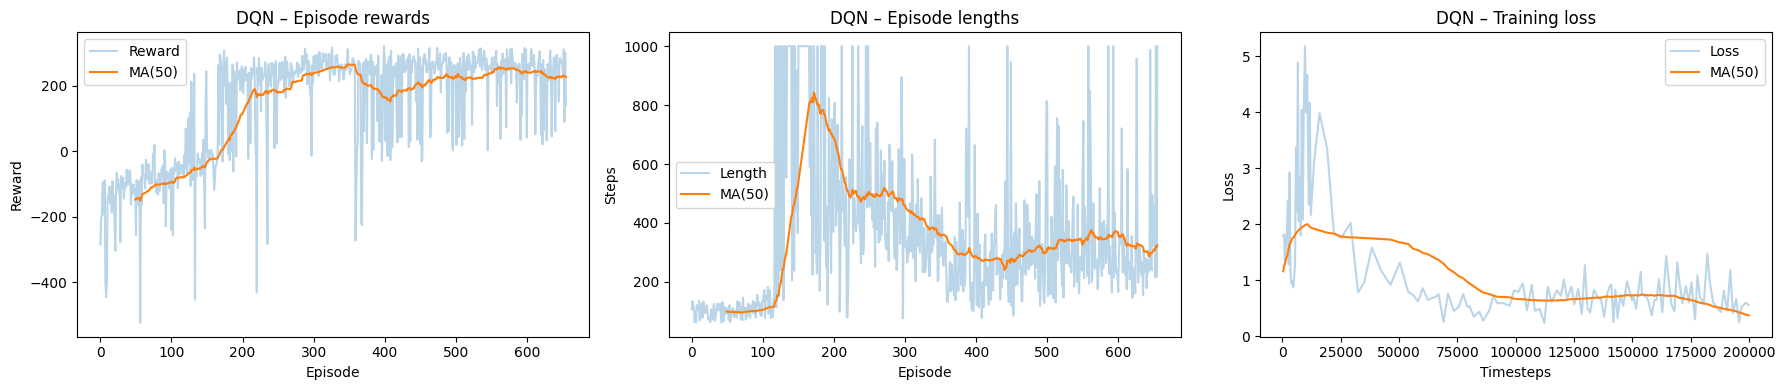

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Saving video to /content/videos/dqn-lunarlander-step-0-to-step-1000.mp4
Moviepy - Building video /content/videos/dqn-lunarlander-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/videos/dqn-lunarlander-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn-lunarlander-step-0-to-step-1000.mp4
Episode 1 finished: total steps=1000, total reward=139.86895751953125


In [ ]:
plot_monitor_curves(dqn_log_dir, algo_name="DQN", rolling_length=50)
record_video("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, model_vid=dqn, video_length=1000, prefix="dqn-lunarlander", verbose=False)
show_videos("videos", prefix="dqn-lunarlander")

Questions:
    
1.  experience replay and a target network are both for the DQN training be stabilization. Experience replay decreases the correlation between samples by storing all the experiences and sampling them randomly. Target network helps to reduce the oscillations by provide a stable target. Reason why we use this are: Frist, the data is not distributed, they has very strong correlation. Second, the target value is changing, it will influence the convergence.

2. DQN value-based method, which means will let the agent learn the action-value function and select the Max one for strategy. It provides ability to leaning, but the random policy has no learning ability, just try all the posibilities.

3. According to the video, the DQN agent much more prefer the hard landing, it will try to land as fast as possible.

## Task 3 – PPO on `LunarLander-v3` (actor–critic, on-policy)

Now you train a **PPO** agent on the same environment.

PPO:

- Directly optimizes a stochastic policy π(a∣s),
- Uses a **clipped** objective to avoid overly large updates,
- Is **on-policy**, using fresh trajectories from the current policy.

The notebook will:

- Train PPO,
- Produce the same style plots (reward, episode length, training signal),
- Evaluate the trained agent,
- Record a **video** of the PPO lander.

**Focus on:**

- How PPO’s learning curve compares to DQN (speed, smoothness).
- Whether PPO appears more or less stable.
- How the policy behaviour in the video differs from DQN.


### Task 3.1: Training PPO on LunarLander-v3

In [ ]:
ppo_log_dir = "logs/ppo_lunarlander"
ppo_total_timesteps = 200000

ppo = train_agent(
    PPO,
    env_id="LunarLander-v3",
    env_kwargs=dict(
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=15.0,
        turbulence_power=1.5,
    ),
    log_dir=ppo_log_dir,
    total_timesteps=ppo_total_timesteps,
    learning_rate=0.003,
    n_epochs = 40,
    n_steps=8192,
    gamma=0.999,
    gae_lambda=0.98,
    clip_range=0.2,
    ent_coef=0.01,
    batch_size = 1024,
    )

Training PPO on LunarLander-v3 for 200000 timesteps...
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: -176.34
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 20000
Best mean reward: -176.34 - Last mean reward per episode: -128.50
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 30000
Best mean reward: -128.50 - Last mean reward per episode: -90.85
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 40000
Best mean reward: -90.85 - Last mean reward per episode: -63.37
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 50000
Best mean reward: -63.37 - Last mean reward per episode: -51.74
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 60000
Best mean reward: -51.74 - Last mean reward per episode: -38.66
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 70000
Best mean reward: -38.66 - Last mean reward per episode: -29.98
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 80000
Best mean reward: -29.98 - Last mean reward per episode: -31.75


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 90000
Best mean reward: -29.98 - Last mean reward per episode: -22.12
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 100000
Best mean reward: -22.12 - Last mean reward per episode: -15.86
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 110000
Best mean reward: -15.86 - Last mean reward per episode: -20.99


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 120000
Best mean reward: -15.86 - Last mean reward per episode: -20.36


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 130000
Best mean reward: -15.86 - Last mean reward per episode: -19.57


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 140000
Best mean reward: -15.86 - Last mean reward per episode: -15.82
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 150000
Best mean reward: -15.82 - Last mean reward per episode: -8.14
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 160000
Best mean reward: -8.14 - Last mean reward per episode: 0.99
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 170000
Best mean reward: 0.99 - Last mean reward per episode: 11.75
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 180000
Best mean reward: 11.75 - Last mean reward per episode: 33.26
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 190000
Best mean reward: 33.26 - Last mean reward per episode: 47.48
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 200000
Best mean reward: 47.48 - Last mean reward per episode: 64.30
Saving new best model to logs/ppo_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training finished in 252.2 seconds.
Evaluating model for 100 episodes...
Episode rewards (first 10): [246.081301, 272.743713, 258.963521, 276.859849, 266.151324, 250.870545, 256.432644, 283.308835, 179.848792, 249.851191]
Episode lengths (first 10): [292, 288, 380, 317, 338, 345, 308, 342, 876, 340]

Average reward over 100 episodes: 235.22 ± 52.36
Average episode length: 382.4 steps
Success rate (reward >= 200): 90.0%


### Task 3.2: Performance of PPO on LunarLander-v3

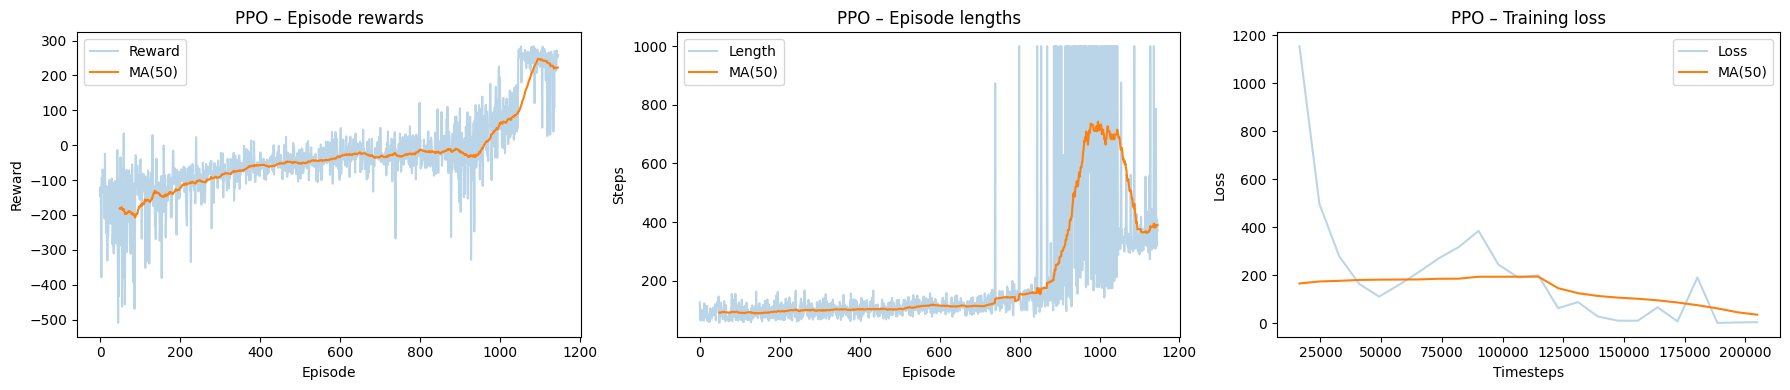

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Saving video to /content/videos/ppo-lunarlander-step-0-to-step-1000.mp4
Moviepy - Building video /content/videos/ppo-lunarlander-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/videos/ppo-lunarlander-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-lunarlander-step-0-to-step-1000.mp4
Episode 1 finished: total steps=1000, total reward=101.00369262695312


In [ ]:
plot_monitor_curves(ppo_log_dir, algo_name="PPO", rolling_length=50)

record_video("LunarLander-v3", model_vid=ppo, video_length=1000, prefix="ppo-lunarlander", verbose=False)
show_videos("videos", prefix="ppo-lunarlander")

Questions:

1. PPO will use the clipping method to avoid from large change of policy, which will destroy the training stability. It will measure the r(new policy/old policy), if the r is to much away from the 1, it will be clipped to avoid from the large change.

2. So compare the DQN, the PPO has more accurancy than DQN, but the example here shows it haven't changes that much. The PPO also uses more steps in training.

3. The PPO, looks like much more do the oscillatory landing, it uses more time to adjust the behavior and the final landing result looks not such well.

## Task 4 – A2C on `LunarLander-v3` (actor–critic, on-policy)

Finally, you train **A2C (Advantage Actor–Critic)** on `LunarLander-v3`.

A2C:

- Maintains both a policy (actor) and value function (critic),
- Uses **advantage estimates** to reduce gradient variance,
- May use an **entropy bonus** to encourage exploration.

The notebook will:

- Train A2C,
- Plot reward, episode length, and training signal,
- Evaluate the trained agent,
- Optionally record a **video** of the A2C lander.

**Think about:**

- How A2C’s learning speed and stability compare to DQN and PPO.
- Whether the critic seems to help (more stable or not).
- What differences you see in behaviour between the three algorithms in the videos.


### Task 4.1: Training A2C on LunarLander-v3

In [ ]:
a2c_log_dir = "logs/a2c_lunarlander"
a2c_total_timesteps = 1000000

a2c = train_agent(
    A2C,
    env_id="LunarLander-v3",
    env_kwargs=dict(
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=15.0,
        turbulence_power=1.5,
    ),
    log_dir=a2c_log_dir,
    total_timesteps=a2c_total_timesteps,
    learning_rate = 0.001,
    n_steps = 200,
    gamma = 0.99,
    gae_lambda=1.0,
    ent_coef = 1.0e-05,
    )

Training A2C on LunarLander-v3 for 1000000 timesteps...
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: -177.65
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 20000
Best mean reward: -177.65 - Last mean reward per episode: -138.30
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 30000
Best mean reward: -138.30 - Last mean reward per episode: -133.24
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 40000
Best mean reward: -133.24 - Last mean reward per episode: -145.98


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 50000
Best mean reward: -133.24 - Last mean reward per episode: -121.17
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 60000
Best mean reward: -121.17 - Last mean reward per episode: -101.51
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 70000
Best mean reward: -101.51 - Last mean reward per episode: -98.34
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 80000
Best mean reward: -98.34 - Last mean reward per episode: -87.40
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 90000
Best mean reward: -87.40 - Last mean reward per episode: -66.44
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 100000
Best mean reward: -66.44 - Last mean reward per episode: -58.22
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 110000
Best mean reward: -58.22 - Last mean reward per episode: -62.82


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 120000
Best mean reward: -58.22 - Last mean reward per episode: -55.86
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 130000
Best mean reward: -55.86 - Last mean reward per episode: -32.51
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 140000
Best mean reward: -32.51 - Last mean reward per episode: -29.96
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 150000
Best mean reward: -29.96 - Last mean reward per episode: -5.12
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 160000
Best mean reward: -5.12 - Last mean reward per episode: 10.68
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 170000
Best mean reward: 10.68 - Last mean reward per episode: 16.94
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 180000
Best mean reward: 16.94 - Last mean reward per episode: 14.32


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 190000
Best mean reward: 16.94 - Last mean reward per episode: 23.24
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 200000
Best mean reward: 23.24 - Last mean reward per episode: 20.67


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 210000
Best mean reward: 23.24 - Last mean reward per episode: 22.80


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 220000
Best mean reward: 23.24 - Last mean reward per episode: 28.45
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 230000
Best mean reward: 28.45 - Last mean reward per episode: 35.16
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 240000
Best mean reward: 35.16 - Last mean reward per episode: 51.47
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 250000
Best mean reward: 51.47 - Last mean reward per episode: 56.52
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 260000
Best mean reward: 56.52 - Last mean reward per episode: 65.61
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 270000
Best mean reward: 65.61 - Last mean reward per episode: 92.34
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 280000
Best mean reward: 92.34 - Last mean reward per episode: 118.29
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 290000
Best mean reward: 118.29 - Last mean reward per episode: 137.33
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 300000
Best mean reward: 137.33 - Last mean reward per episode: 144.88
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 310000
Best mean reward: 144.88 - Last mean reward per episode: 139.78


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 320000
Best mean reward: 144.88 - Last mean reward per episode: 130.02


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 330000
Best mean reward: 144.88 - Last mean reward per episode: 124.42


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 340000
Best mean reward: 144.88 - Last mean reward per episode: 131.10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 350000
Best mean reward: 144.88 - Last mean reward per episode: 134.10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 360000
Best mean reward: 144.88 - Last mean reward per episode: 154.01
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 370000
Best mean reward: 154.01 - Last mean reward per episode: 158.96
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 380000
Best mean reward: 158.96 - Last mean reward per episode: 156.60


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 390000
Best mean reward: 158.96 - Last mean reward per episode: 137.81


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 400000
Best mean reward: 158.96 - Last mean reward per episode: 135.44


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 410000
Best mean reward: 158.96 - Last mean reward per episode: 126.11


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 420000
Best mean reward: 158.96 - Last mean reward per episode: 133.63


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 430000
Best mean reward: 158.96 - Last mean reward per episode: 158.16


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 440000
Best mean reward: 158.96 - Last mean reward per episode: 156.56


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 450000
Best mean reward: 158.96 - Last mean reward per episode: 157.81


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 460000
Best mean reward: 158.96 - Last mean reward per episode: 133.48


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 470000
Best mean reward: 158.96 - Last mean reward per episode: 133.84


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 480000
Best mean reward: 158.96 - Last mean reward per episode: 117.27


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 490000
Best mean reward: 158.96 - Last mean reward per episode: 129.99


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 500000
Best mean reward: 158.96 - Last mean reward per episode: 102.41


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 510000
Best mean reward: 158.96 - Last mean reward per episode: 110.77


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 520000
Best mean reward: 158.96 - Last mean reward per episode: 101.76


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 530000
Best mean reward: 158.96 - Last mean reward per episode: 117.61


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 540000
Best mean reward: 158.96 - Last mean reward per episode: 138.91


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 550000
Best mean reward: 158.96 - Last mean reward per episode: 156.83


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 560000
Best mean reward: 158.96 - Last mean reward per episode: 185.90
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 570000
Best mean reward: 185.90 - Last mean reward per episode: 189.02
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 580000
Best mean reward: 189.02 - Last mean reward per episode: 196.17
Saving new best model to logs/a2c_lunarlander/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 590000
Best mean reward: 196.17 - Last mean reward per episode: 172.86


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 600000
Best mean reward: 196.17 - Last mean reward per episode: 189.42


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 610000
Best mean reward: 196.17 - Last mean reward per episode: 185.65


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 620000
Best mean reward: 196.17 - Last mean reward per episode: 172.44


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 630000
Best mean reward: 196.17 - Last mean reward per episode: 159.36


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 640000
Best mean reward: 196.17 - Last mean reward per episode: 135.92


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 650000
Best mean reward: 196.17 - Last mean reward per episode: 147.53


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 660000
Best mean reward: 196.17 - Last mean reward per episode: 167.91


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 670000
Best mean reward: 196.17 - Last mean reward per episode: 184.72


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 680000
Best mean reward: 196.17 - Last mean reward per episode: 183.47


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 690000
Best mean reward: 196.17 - Last mean reward per episode: 179.74


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 700000
Best mean reward: 196.17 - Last mean reward per episode: 185.76


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 710000
Best mean reward: 196.17 - Last mean reward per episode: 167.67


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 720000
Best mean reward: 196.17 - Last mean reward per episode: 150.80


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 730000
Best mean reward: 196.17 - Last mean reward per episode: 123.62


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 740000
Best mean reward: 196.17 - Last mean reward per episode: 121.09


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 750000
Best mean reward: 196.17 - Last mean reward per episode: 163.75


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 760000
Best mean reward: 196.17 - Last mean reward per episode: 175.84


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 770000
Best mean reward: 196.17 - Last mean reward per episode: 183.67


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 780000
Best mean reward: 196.17 - Last mean reward per episode: 170.32


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 790000
Best mean reward: 196.17 - Last mean reward per episode: 150.57


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 800000
Best mean reward: 196.17 - Last mean reward per episode: 142.19


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 810000
Best mean reward: 196.17 - Last mean reward per episode: 144.23


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 820000
Best mean reward: 196.17 - Last mean reward per episode: 160.16


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 830000
Best mean reward: 196.17 - Last mean reward per episode: 163.71


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 840000
Best mean reward: 196.17 - Last mean reward per episode: 169.55


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 850000
Best mean reward: 196.17 - Last mean reward per episode: 164.49


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 860000
Best mean reward: 196.17 - Last mean reward per episode: 152.92


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 870000
Best mean reward: 196.17 - Last mean reward per episode: 156.16


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 880000
Best mean reward: 196.17 - Last mean reward per episode: 142.76


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 890000
Best mean reward: 196.17 - Last mean reward per episode: 142.80


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 900000
Best mean reward: 196.17 - Last mean reward per episode: 172.50


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 910000
Best mean reward: 196.17 - Last mean reward per episode: 157.35


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 920000
Best mean reward: 196.17 - Last mean reward per episode: 134.63


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 930000
Best mean reward: 196.17 - Last mean reward per episode: 141.29


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 940000
Best mean reward: 196.17 - Last mean reward per episode: 162.35


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 950000
Best mean reward: 196.17 - Last mean reward per episode: 160.66


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 960000
Best mean reward: 196.17 - Last mean reward per episode: 181.53


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 970000
Best mean reward: 196.17 - Last mean reward per episode: 183.75


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 980000
Best mean reward: 196.17 - Last mean reward per episode: 162.91


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 990000
Best mean reward: 196.17 - Last mean reward per episode: 149.57


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 1000000
Best mean reward: 196.17 - Last mean reward per episode: 133.71
Training finished in 978.2 seconds.
Evaluating model for 100 episodes...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode rewards (first 10): [220.162959, 6.87432, 114.586378, 272.669704, 15.316538, -32.470495, 248.113924, 35.713018, 206.709971, -28.769293]
Episode lengths (first 10): [239, 216, 1000, 228, 213, 290, 308, 183, 301, 190]

Average reward over 100 episodes: 156.73 ± 118.09
Average episode length: 316.1 steps
Success rate (reward >= 200): 59.0%


### Task 4.2: Performance of A2C on LunarLander-v3

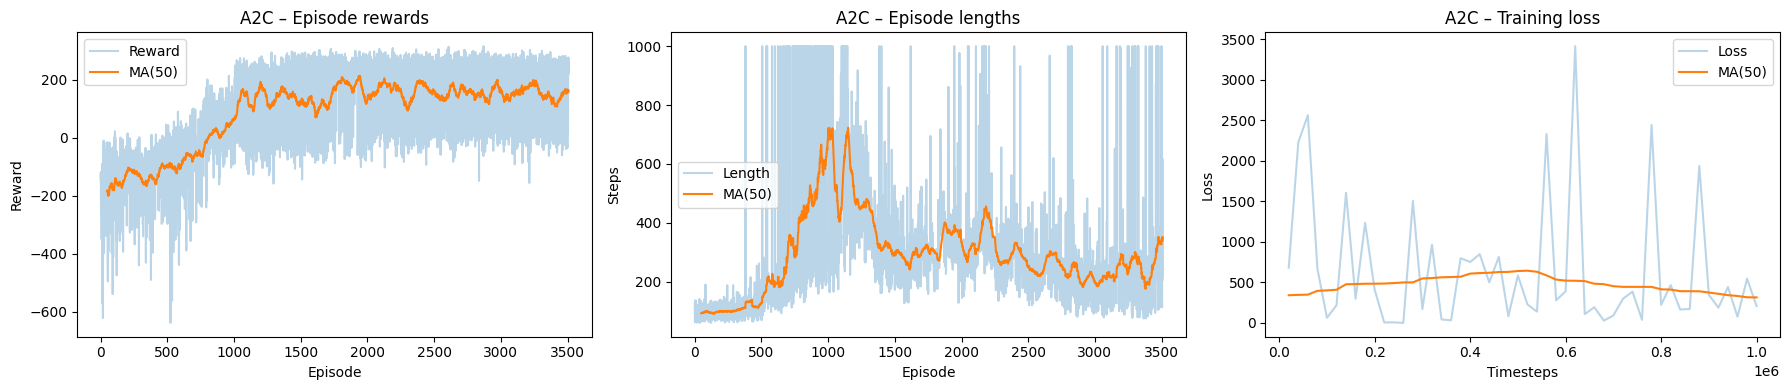

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode 1 finished: total steps=258, total reward=-46.21116256713867
Episode 2 finished: total steps=160, total reward=22.431167602539062
Episode 3 finished: total steps=248, total reward=239.38746643066406
Episode 4 finished: total steps=208, total reward=291.71417236328125
Saving video to /content/videos/a2c-lunarlander-step-0-to-step-1000.mp4
Moviepy - Building video /content/videos/a2c-lunarlander-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/videos/a2c-lunarlander-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/a2c-lunarlander-step-0-to-step-1000.mp4


In [ ]:
plot_monitor_curves(a2c_log_dir, algo_name="A2C", rolling_length=50)

record_video("LunarLander-v3", model_vid=a2c, video_length=1000, prefix="a2c-lunarlander", verbose=False)
show_videos("videos", prefix="a2c-lunarlander")

Questions:

1. The critic helps to reduce the variance of the policy gradient, it will provide the value to let the agent know how good the current state is, it also help to increase the training efficiency.

2. It much more worse than both DQN and PPO, the learning curve is unstable and it speed is faster than DQN and PPO, but it oscillatory so much.

3. The A2C agent did very unstable landing, it sometimes very good and fast, but sometimes it almost crash.

## Task 5 – Comparing DQN, PPO, and A2C on `LunarLander-v3`

Use your knowledge, plots, evaluation statistics and videos to talk about the specification of these three algorithms:

- Type (value-based / policy gradient / actor–critic),
- On-policy vs off-policy,
- Exploration mechanism,
- Rough sample efficiency (for this lab),
- Stability (noisy vs smooth),
- Notes about behaviour on LunarLander-v3.

**Questions to think about:**

- Which algorithm performed best in your runs?
- Which learned fastest?
- Which was most stable?
- How do the theoretical differences (on/off-policy, critic, replay) show up in practice here?


### Task 5: Quick head-to-head comparison

In [ ]:
episodes=100
success_threshold=200

print(f"=== Quick Evaluation ({episodes} episodes, deterministic) ===")
for name, model in [("DQN", dqn), ("PPO", ppo), ("A2C", a2c)]:
    mean_r, std_r, avg_length, success_rate, ep_rewards, ep_lengths = quick_eval(model, "LunarLander-v3", episodes=episodes, success_threshold=success_threshold)
    print(f"\n{name}: Episode rewards (first 10):", ep_rewards[:10])
    print(f"{name}: Episode lengths (first 10):", ep_lengths[:10])
    print(f"{name}: Average reward over {episodes} episodes: {mean_r:.2f} ± {std_r:.2f}")
    print(f"{name}: Average episode length: {avg_length:.1f} steps")
    print(f"{name}: Success rate (reward >= {success_threshold}): {success_rate:.1%}")

=== Quick Evaluation (100 episodes, deterministic) ===

DQN: Episode rewards (first 10): [274.878683, 268.236894, 181.034067, 245.987, 218.181668, 47.748613, 41.185074, 222.095634, 218.736424, 255.998411]
DQN: Episode lengths (first 10): [240, 446, 1000, 347, 470, 166, 170, 421, 662, 585]
DQN: Average reward over 100 episodes: 226.10 ± 73.14
DQN: Average episode length: 400.4 steps
DQN: Success rate (reward >= 200): 79.0%

PPO: Episode rewards (first 10): [258.25041, 213.177482, 227.001608, 244.27943, 265.116841, 272.785176, 266.668965, 262.130476, 226.905652, 242.006313]
PPO: Episode lengths (first 10): [350, 307, 401, 344, 364, 300, 355, 300, 296, 307]
PPO: Average reward over 100 episodes: 226.44 ± 59.31
PPO: Average episode length: 404.0 steps
PPO: Success rate (reward >= 200): 85.0%

A2C: Episode rewards (first 10): [270.206591, 236.338536, 247.262272, 49.887868, 218.32014, 253.258762, 116.886775, 236.375195, 254.369555, -23.599764]
A2C: Episode lengths (first 10): [328, 232, 258,

Questions:

Learning speed: The A2C is much more faster than DQN and PPO, the PPO is the slowest one.

Stability: The PPO is much more stable than the DQN and A2C, the A2C is the worst one.

Final performance: The PPO also the best one, DQN is the second, the A2C is the worst.

Exploration: The DQN greedy exploration is better than the random exploration or A2C.

Behaviour in videos: So PPO is much more close to the smooth landing, the DQN is much more like the hard landing, the A2C is very unstable.

Algorithmic insight: The value-based algorithm is much more care the Q value, it sometimes changes fast because it cares about the max Q, the  policy-gradient algorithm is much more better than the value-based one, it cares about the whole policy, it will not change that much because it cares about the whole policy distribution. The actor-critic one is more better because it introduces the critic to help change more gently. The on-policy and off-policy difference in the usage of data, the off-policy one needs less data but the on-policy one needs more data.

## Task 6 (Optional) – DQN, PPO, and A2C on `CartPole-v1`

This optional section repeats the experiments on the simpler control task `CartPole-v1`.

The notebook provides cells to:

- Train DQN, PPO, and A2C on CartPole,
- Plot their learning curves,
- Record short videos.

**Use this to compare tasks:**

- Do all three methods learn CartPole? Much faster than LunarLander?
- Does the ranking of algorithms (best/worst) stay the same?
- What does this tell you about the influence of the environment on algorithm choice?


### Task 6.1: Performance of DQN on CartPole-v1

Training DQN on CartPole-v1 for 150000 timesteps...
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 31.54
Saving new best model to logs/dqn_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 20000
Best mean reward: 31.54 - Last mean reward per episode: 53.93
Saving new best model to logs/dqn_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 30000
Best mean reward: 53.93 - Last mean reward per episode: 136.69
Saving new best model to logs/dqn_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 40000
Best mean reward: 136.69 - Last mean reward per episode: 227.57
Saving new best model to logs/dqn_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 50000
Best mean reward: 227.57 - Last mean reward per episode: 307.76
Saving new best model to logs/dqn_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 60000
Best mean reward: 307.76 - Last mean reward per episode: 273.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 70000
Best mean reward: 307.76 - Last mean reward per episode: 123.16


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 80000
Best mean reward: 307.76 - Last mean reward per episode: 131.53


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 90000
Best mean reward: 307.76 - Last mean reward per episode: 123.46


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 100000
Best mean reward: 307.76 - Last mean reward per episode: 99.62


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 110000
Best mean reward: 307.76 - Last mean reward per episode: 108.17


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 120000
Best mean reward: 307.76 - Last mean reward per episode: 167.17


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 130000
Best mean reward: 307.76 - Last mean reward per episode: 232.30


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 140000
Best mean reward: 307.76 - Last mean reward per episode: 316.70
Saving new best model to logs/dqn_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 150000
Best mean reward: 316.70 - Last mean reward per episode: 334.22
Saving new best model to logs/dqn_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training finished in 257.7 seconds.
Evaluating model for 100 episodes...
Episode rewards (first 10): [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Episode lengths (first 10): [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

Average reward over 100 episodes: 500.00 ± 0.00
Average episode length: 500.0 steps
Success rate (reward >= 500): 100.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


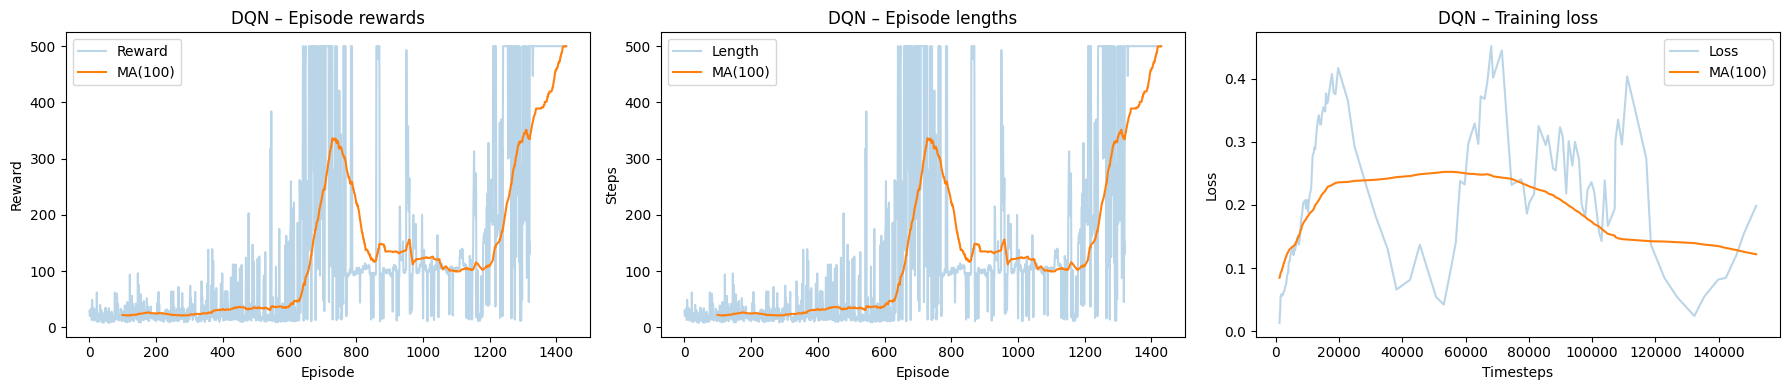

Saving video to /content/videos/dqn-cartpole-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/dqn-cartpole-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/dqn-cartpole-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn-cartpole-step-0-to-step-500.mp4
Episode 1 finished: total steps=500, total reward=500.0


In [ ]:
dqn_log_dir = "logs/dqn_cartpole"
dqn_total_timesteps = 150000

dqn = train_agent(
    DQN,
    env_id="CartPole-v1",
    log_dir=dqn_log_dir,
    total_timesteps=dqn_total_timesteps,
    batch_size = 512,
    buffer_size = 10000,
    exploration_initial_eps=1.0,
    exploration_fraction = 0.16,
    exploration_final_eps = 0.04,
    gamma = 0.99,
    gradient_steps = 128,
    learning_rate = 0.002,
    learning_starts = 1000,
    target_update_interval=10,
    train_freq = (10, "episode"),
    policy_kwargs = dict(net_arch=[256, 256]),
    success_threshold=500,
    )


plot_monitor_curves(dqn_log_dir, algo_name="DQN", rolling_length=100)
record_video("CartPole-v1", model_vid=dqn, video_length=500, prefix="dqn-cartpole", verbose=False)
show_videos("videos", prefix="dqn-cartpole")

### Task 6.2: Performance of PPO on CartPole-v1

Training PPO on CartPole-v1 for 150000 timesteps...
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 102.88
Saving new best model to logs/ppo_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 20000
Best mean reward: 102.88 - Last mean reward per episode: 166.27
Saving new best model to logs/ppo_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 30000
Best mean reward: 166.27 - Last mean reward per episode: 253.35
Saving new best model to logs/ppo_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 40000
Best mean reward: 253.35 - Last mean reward per episode: 298.75
Saving new best model to logs/ppo_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 50000
Best mean reward: 298.75 - Last mean reward per episode: 388.21
Saving new best model to logs/ppo_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 60000
Best mean reward: 388.21 - Last mean reward per episode: 452.96
Saving new best model to logs/ppo_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 70000
Best mean reward: 452.96 - Last mean reward per episode: 500.00
Saving new best model to logs/ppo_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 80000
Best mean reward: 500.00 - Last mean reward per episode: 500.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 90000
Best mean reward: 500.00 - Last mean reward per episode: 500.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 100000
Best mean reward: 500.00 - Last mean reward per episode: 500.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 110000
Best mean reward: 500.00 - Last mean reward per episode: 500.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 120000
Best mean reward: 500.00 - Last mean reward per episode: 500.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 130000
Best mean reward: 500.00 - Last mean reward per episode: 500.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 140000
Best mean reward: 500.00 - Last mean reward per episode: 500.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 150000
Best mean reward: 500.00 - Last mean reward per episode: 500.00
Training finished in 557.3 seconds.
Evaluating model for 100 episodes...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode rewards (first 10): [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Episode lengths (first 10): [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

Average reward over 100 episodes: 500.00 ± 0.00
Average episode length: 500.0 steps
Success rate (reward >= 500): 100.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


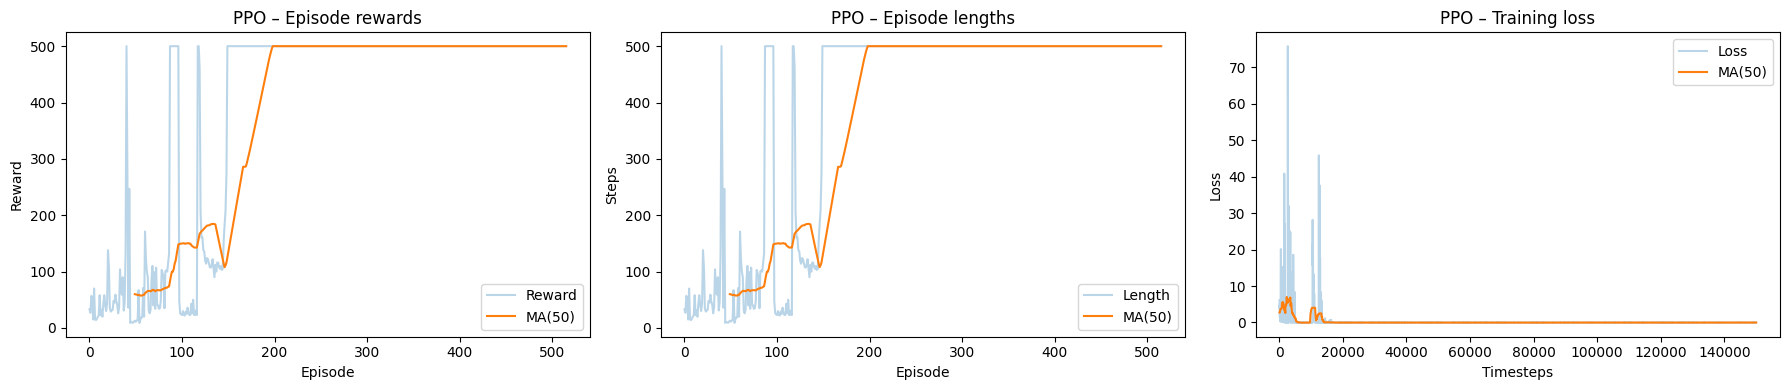

Saving video to /content/videos/ppo-cartpole-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/ppo-cartpole-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/ppo-cartpole-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-cartpole-step-0-to-step-500.mp4
Episode 1 finished: total steps=500, total reward=500.0


In [ ]:
ppo_log_dir = "logs/ppo_cartpole"
ppo_total_timesteps = 150000

ppo = train_agent(
    PPO,
    env_id="CartPole-v1",
    log_dir=ppo_log_dir,
    total_timesteps=ppo_total_timesteps,
    batch_size = 256,
    clip_range = 0.2,
    ent_coef = 0.0,
    gae_lambda = 0.8,
    gamma = 0.98,
    learning_rate = 0.001,
    n_epochs = 20,
    n_steps = 32,
    success_threshold=500,
    )

plot_monitor_curves(ppo_log_dir, algo_name="PPO", rolling_length=50)

record_video("CartPole-v1", model_vid=ppo, video_length=500, prefix="ppo-cartpole", verbose=False)
show_videos("videos", prefix="ppo-cartpole")

### Task 6.3: Performance of A2C on CartPole-v1

Training A2C on CartPole-v1 for 150000 timesteps...
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 75.85
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 20000
Best mean reward: 75.85 - Last mean reward per episode: 160.43
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 30000
Best mean reward: 160.43 - Last mean reward per episode: 63.53


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 40000
Best mean reward: 160.43 - Last mean reward per episode: 104.38


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 50000
Best mean reward: 160.43 - Last mean reward per episode: 198.44
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 60000
Best mean reward: 198.44 - Last mean reward per episode: 294.99
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 70000
Best mean reward: 294.99 - Last mean reward per episode: 392.65
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 80000
Best mean reward: 392.65 - Last mean reward per episode: 469.90
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 90000
Best mean reward: 469.90 - Last mean reward per episode: 471.58
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 100000
Best mean reward: 471.58 - Last mean reward per episode: 471.58


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 110000
Best mean reward: 471.58 - Last mean reward per episode: 471.58


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 120000
Best mean reward: 471.58 - Last mean reward per episode: 492.86
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 130000
Best mean reward: 492.86 - Last mean reward per episode: 495.16
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 140000
Best mean reward: 495.16 - Last mean reward per episode: 498.60
Saving new best model to logs/a2c_cartpole/best_model


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Num timesteps: 150000
Best mean reward: 498.60 - Last mean reward per episode: 495.87
Training finished in 257.5 seconds.
Evaluating model for 100 episodes...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode rewards (first 10): [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Episode lengths (first 10): [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

Average reward over 100 episodes: 500.00 ± 0.00
Average episode length: 500.0 steps
Success rate (reward >= 500): 100.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


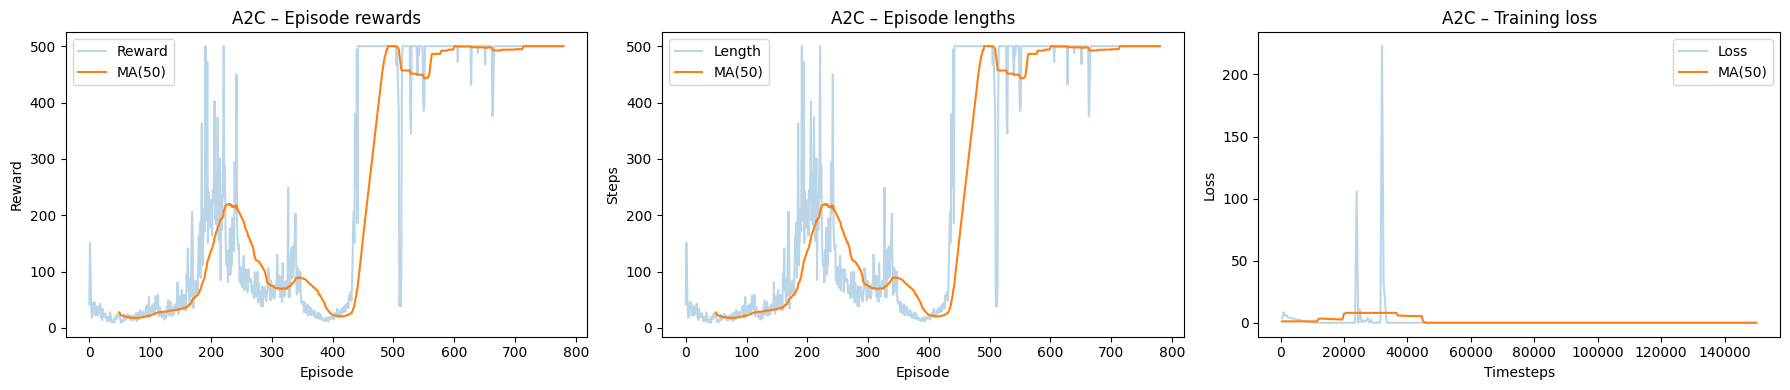

Saving video to /content/videos/a2c-cartpole-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/a2c-cartpole-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/a2c-cartpole-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/a2c-cartpole-step-0-to-step-500.mp4
Episode 1 finished: total steps=500, total reward=500.0


In [ ]:
a2c_log_dir = "logs/a2c_cartpole"
a2c_total_timesteps = 150000

a2c = train_agent(
    A2C,
    env_id="CartPole-v1",
    log_dir=a2c_log_dir,
    total_timesteps=a2c_total_timesteps,
    ent_coef=0.00,
    success_threshold=500,
)

plot_monitor_curves(a2c_log_dir, algo_name="A2C", rolling_length=50, a2c_ent_coef=0)

record_video("CartPole-v1", model_vid=a2c, video_length=500, prefix="a2c-cartpole", verbose=False)
show_videos("videos", prefix="a2c-cartpole")

### Task 6.4: Quick head-to-head performance comparison on CartPole-v1

In [ ]:
episodes=100
success_threshold=500

print(f"=== Quick Evaluation ({episodes} episodes, deterministic) ===")
for name, model in [("DQN", dqn), ("PPO", ppo), ("A2C", a2c)]:
    mean_r, std_r, avg_length, success_rate, ep_rewards, ep_lengths = quick_eval(model, "CartPole-v1", episodes=episodes, success_threshold=success_threshold)
    print(f"\n{name}: Episode rewards (first 10):", ep_rewards[:10])
    print(f"{name}: Episode lengths (first 10):", ep_lengths[:10])
    print(f"{name}: Average reward over {episodes} episodes: {mean_r:.2f} ± {std_r:.2f}")
    print(f"{name}: Average episode length: {avg_length:.1f} steps")
    print(f"{name}: Success rate (reward >= {success_threshold}): {success_rate:.1%}")

=== Quick Evaluation (100 episodes, deterministic) ===

DQN: Episode rewards (first 10): [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
DQN: Episode lengths (first 10): [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
DQN: Average reward over 100 episodes: 500.00 ± 0.00
DQN: Average episode length: 500.0 steps
DQN: Success rate (reward >= 500): 100.0%

PPO: Episode rewards (first 10): [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
PPO: Episode lengths (first 10): [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
PPO: Average reward over 100 episodes: 500.00 ± 0.00
PPO: Average episode length: 500.0 steps
PPO: Success rate (reward >= 500): 100.0%

A2C: Episode rewards (first 10): [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
A2C: Episode lengths (first 10): [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
A2C: Average reward over 100 episodes: 500.00 ± 0.00
A2C: Average episode length: 500.0 steps
A2C: Success